# Improving Efficiency & Production Process of Electric Vehicles using Data Science Techniques

This challenge has been designed to provide with you hands-on understanding of data science problems in commercial EVs’ production and optimization in most advanced motor technologies used by companies like Tesla, BMW and Ford. 

It is often a challenging and complex task to measure rotor and stator temperatures in commercial electric vehicles. Even if these specific tasks can be completed successfully, these testing processes cannot be classified as economical for manufacturers. Keeping in mind that the temperature data have significant importance on dynamical responses of vehicles and motors’ performances, there is an emerging need for new proposals and scientific contributions in this domain.

Consider, one manufacturer of electric cars hired you to propose an estimator for the stator and rotor temperatures and design a predictive machine learning or deep learning model. Such a model could significantly help your new company to utilize new control strategies of the motors and maximize their operational performances. If you build an accurate ML/DL model, the needs of the company for implementing additional temperature sensors in vehicles will be reduced. The potential contribution will directly result in lowering car construction and maintenance costs, and will convince the company to invest further in hiring DS experts like you.

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as plt
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff

from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

from scipy.stats import norm, skew #for some statistics

import xgboost

In [2]:
train_df=pd.read_csv("train_set.csv")
test_df=pd.read_csv("test_set.csv")
test_true=pd.read_csv("test_solutions.csv")

In [3]:
train_df.shape
#test_df.shape

(846368, 13)

In [4]:
#check for nan values
train_df.isnull().sum()

ambient           0
coolant           0
u_d               0
u_q               0
motor_speed       0
torque            0
i_d               0
i_q               0
pm                0
stator_yoke       0
stator_tooth      0
stator_winding    0
profile_id        0
dtype: int64

In [5]:
train_df['profile_id'].value_counts()

20    43970
6     40387
65    40093
66    36475
27    35360
4     33423
58    33381
56    33122
53    32441
79    31153
44    26340
70    25676
30    23862
80    23823
74    23760
68    23330
36    22608
76    22187
48    21982
29    21357
81    17671
45    17141
63    16667
69    15349
72    15300
10    15255
77    14621
60    14542
57    14402
75    13471
67    11134
49    10815
50    10809
55    10806
54    10806
78     8444
43     8442
11     7886
59     7474
64     6249
46     2179
47     2175
Name: profile_id, dtype: int64

In [6]:
train_df.drop(labels=['profile_id'],axis=1,inplace=True)


## Distribution Plots

In [7]:
test_df_temp=pd.concat([test_df,test_true],axis=1)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0542a8e9d0>,
      dtype=object)

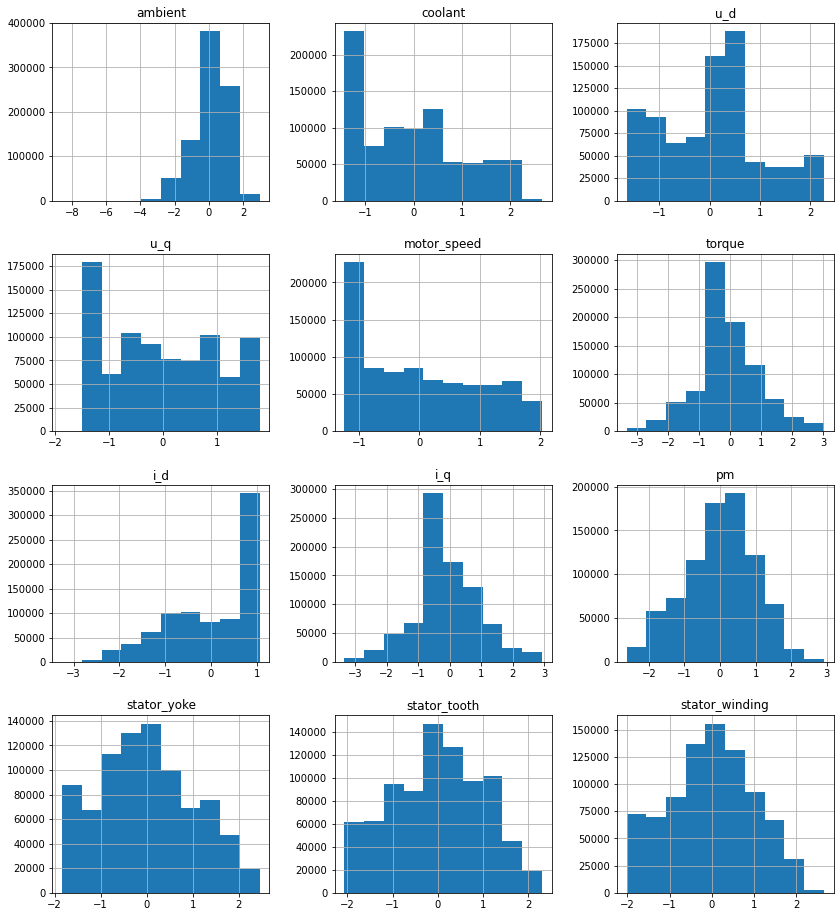

In [8]:
#Distribution plots of train dataset
n= len(train_df.columns)
   
train_df.hist(figsize= (14,16))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0541218790>,
      dtype=object)

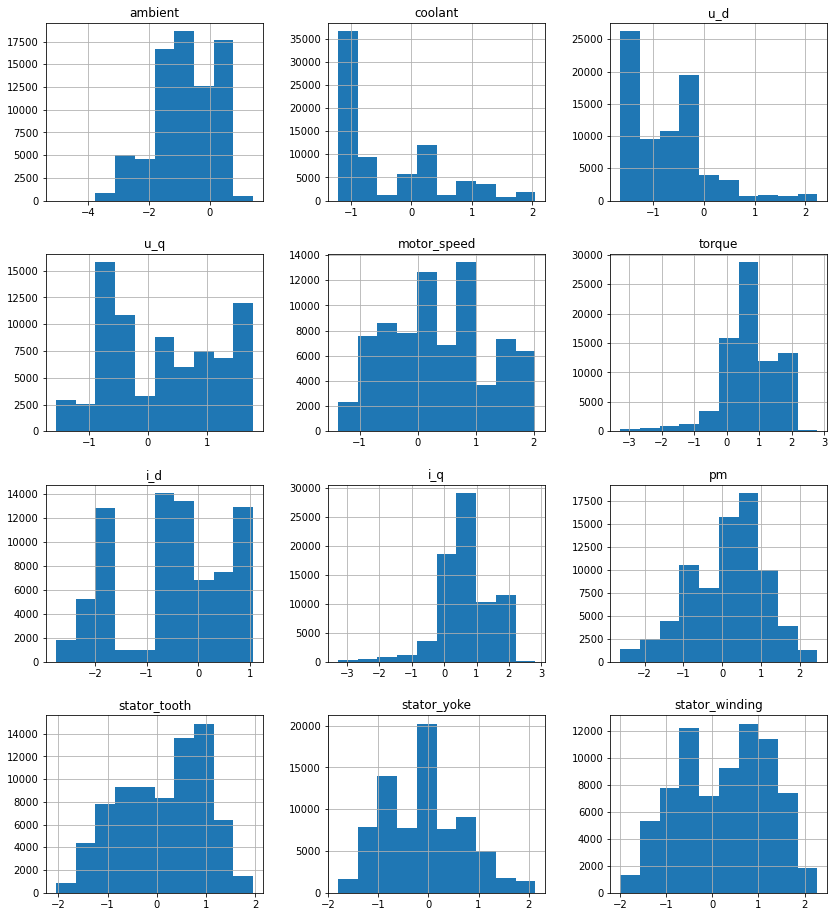

In [9]:
#distribution plot of test dataset
test_df_temp.hist(figsize= (14,16))    

## Check for skewness

In [10]:
numeric_feats = train_df.dtypes[train_df.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = train_df[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
coolant,0.591946
motor_speed,0.351135
stator_yoke,0.222259
u_q,0.182180
u_d,0.163064
torque,0.021879
i_q,-0.014694
stator_winding,-0.039838
stator_tooth,-0.076183
pm,-0.214174


## Train/Validation split

In [11]:
test_temp,train_temp=train_test_split(test_df_temp,test_size=0.3,shuffle=True, random_state=1)

In [12]:
test_temp,val_temp=train_test_split(test_temp,test_size=0.4,shuffle=True, random_state=1)

In [13]:
val_temp.shape

(21399, 12)

In [14]:
train_df=pd.concat([train_df,train_temp])

In [15]:
train_df.shape

(869295, 12)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0541848fd0>,
      dtype=object)

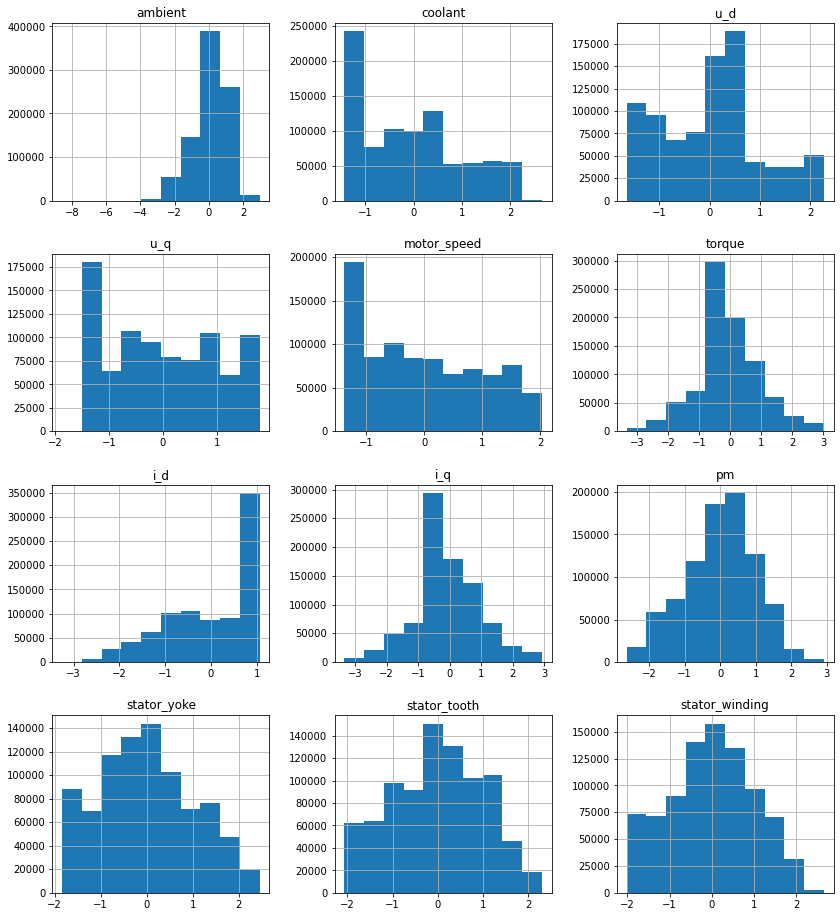

In [16]:
train_df.hist(figsize= (14,16))

## Correlation plot

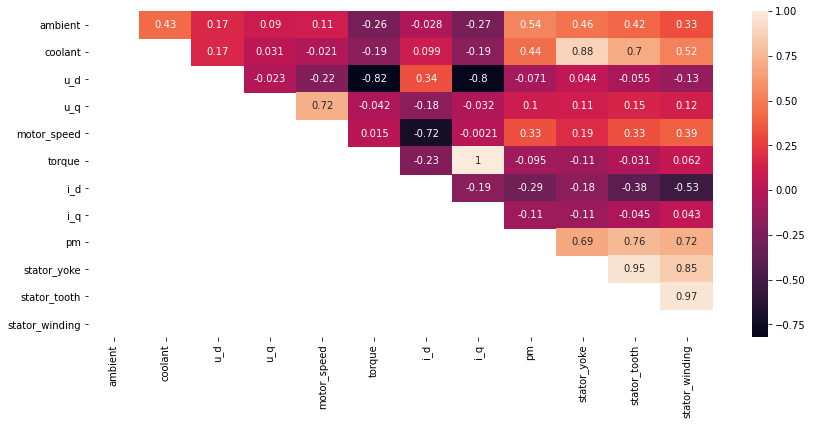

In [17]:
#training dataset
plt.pyplot.figure(figsize=(14,6))
correlation_matrix=np.tril(train_df.corr())
sns.heatmap(train_df.corr(),annot=True,fmt='.2g' ,mask=correlation_matrix)

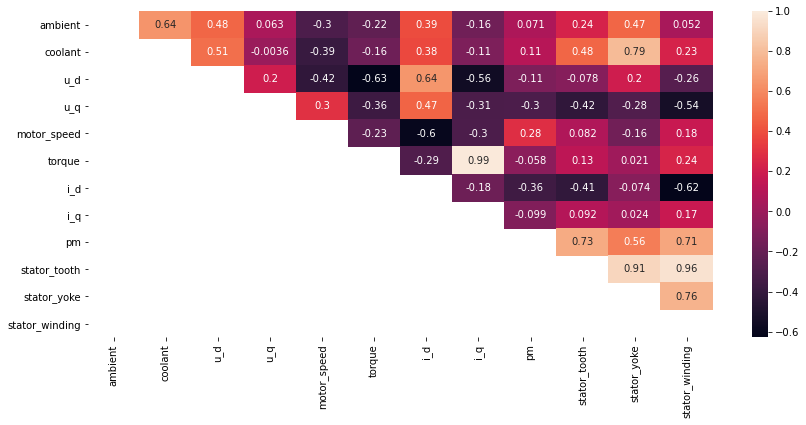

In [18]:
#test dataset
plt.pyplot.figure(figsize=(14,6))
correlation_matrix_test=np.tril(test_df_temp.corr())
sns.heatmap(test_df_temp.corr(),annot=True,fmt='.2g' ,mask=correlation_matrix_test)

## Deal With Multicollinearity

In [19]:
train_df.drop(labels=['torque'],axis=1,inplace=True)
val_temp.drop(labels=['torque'],axis=1,inplace=True)
test_df.drop(labels=['torque'],axis=1,inplace=True)



In [20]:
train_df

,ambient,coolant,u_d,u_q,motor_speed,i_d,i_q,pm,stator_yoke,stator_tooth,stator_winding
0,-0.752143,-1.118446,0.327935,-1.297858,-1.222428,1.029572,-0.245860,-2.522071,-1.831422,-2.066143,-2.018033
1,-0.771263,-1.117021,0.329665,-1.297686,-1.222429,1.029509,-0.245832,-2.522418,-1.830969,-2.064859,-2.017631
2,-0.782892,-1.116681,0.332771,-1.301822,-1.222428,1.029448,-0.245818,-2.522673,-1.830400,-2.064073,-2.017343
3,-0.780935,-1.116764,0.333700,-1.301852,-1.222430,1.032845,-0.246955,-2.521639,-1.830333,-2.063137,-2.017632
4,-0.774043,-1.116775,0.335206,-1.303118,-1.222429,1.031807,-0.246610,-2.521900,-1.830498,-2.062795,-2.018145
...,...,...,...,...,...,...,...,...,...,...,...
11195,-1.168872,-1.050427,-1.115377,0.792591,0.941938,-0.769302,0.447383,0.110786,-0.785166,-0.517548,-0.398468
75555,0.688486,1.167703,2.097396,-0.033507,0.394496,-0.934021,-1.695368,1.080125,1.030856,0.910100,0.688163
56196,0.681706,-0.578425,-0.322072,1.594412,0.671393,0.178584,0.082054,-1.275169,-0.885058,-0.978530,-1.080349
35929,-0.814940,-1.049214,-1.599150,-0.586802,0.856992,-1.910549,0.798512,0.328817,-0.224949,0.398125,0.905600


In [21]:
##X,Y variables
X_train=train_df.drop(labels=['pm','stator_yoke','stator_tooth','stator_winding'],axis=1)
y_train = train_df[['pm','stator_yoke','stator_tooth','stator_winding']]
X_val=val_temp.drop(labels=['pm','stator_yoke','stator_tooth','stator_winding'],axis=1)
y_val=val_temp[['pm','stator_yoke','stator_tooth','stator_winding']]


In [22]:
#X_train,X_val,y_train,y_val=train_test_split(train_df.drop(labels=['pm','stator_yoke','stator_tooth','stator_winding'],axis=1),
#                                             train_df[['pm','stator_yoke','stator_tooth','stator_winding']],
#                                             test_size=0.1,random_state=1)


In [23]:
X_train.shape

(869295, 7)

In [24]:
X_val.shape

(21399, 7)

In [25]:
y_train.iloc[:,0]

0       -2.522071
1       -2.522418
2       -2.522673
3       -2.521639
4       -2.521900
           ...   
11195    0.110786
75555    1.080125
56196   -1.275169
35929    0.328817
49349    0.424353
Name: pm, Length: 869295, dtype: float64

## Base XGBoost Model to predict multi dimensional output

In [26]:
# define base xgboost model
XGBmodel = xgboost.XGBRegressor(max_depth=3,n_estimators=500,gamma=0.01, min_child_weight=1)

# define the direct multioutput wrapper model
XGB_wrapper=MultiOutputRegressor(XGBmodel)

In [27]:
#fit the basic model
XGB_wrapper.fit(X_train, y_train)

MultiOutputRegressor(estimator=XGBRegressor(base_score=None, booster=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, gamma=0.01,
                                            gpu_id=None, importance_type='gain',
                                            interaction_constraints=None,
                                            learning_rate=None,
                                            max_delta_step=None, max_depth=3,
                                            min_child_weight=1, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=500, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, reg_alpha=None,
                                            

In [28]:
X_train
#X_val

,ambient,coolant,u_d,u_q,motor_speed,i_d,i_q
0,-0.752143,-1.118446,0.327935,-1.297858,-1.222428,1.029572,-0.245860
1,-0.771263,-1.117021,0.329665,-1.297686,-1.222429,1.029509,-0.245832
2,-0.782892,-1.116681,0.332771,-1.301822,-1.222428,1.029448,-0.245818
3,-0.780935,-1.116764,0.333700,-1.301852,-1.222430,1.032845,-0.246955
4,-0.774043,-1.116775,0.335206,-1.303118,-1.222429,1.031807,-0.246610
...,...,...,...,...,...,...,...
11195,-1.168872,-1.050427,-1.115377,0.792591,0.941938,-0.769302,0.447383
75555,0.688486,1.167703,2.097396,-0.033507,0.394496,-0.934021,-1.695368
56196,0.681706,-0.578425,-0.322072,1.594412,0.671393,0.178584,0.082054
35929,-0.814940,-1.049214,-1.599150,-0.586802,0.856992,-1.910549,0.798512


In [29]:
y_hat=XGB_wrapper.predict(X_val)

In [30]:
#show predicted values
print('Predicted: %s' % y_hat)

Predicted: [[-1.2737734  -0.93039167 -0.0581705   0.72234845]
 [ 0.33239406  0.5029353   0.54524875  0.50432247]
 [ 0.25175506 -0.7859303  -0.3676731  -0.27269983]
 ...
 [-0.09731334 -0.21984327  0.2210542   0.40394527]
 [ 2.0858088   0.08098376  1.0213332   1.3163285 ]
 [ 0.7027139   1.2070993   1.1218846   1.0603733 ]]


In [31]:
#Root Mean Squared Error
mean_squared_error(y_val, y_hat, squared=False)

0.32344807944832293

In [ ]:
#Mean Squared Error
mean_squared_error(y_val, y_hat, squared=True)

0.10810006641097014

In [ ]:
#R^2
r2_score(y_val, y_hat)

0.8703350651002012

In [ ]:
test_df

,ambient,coolant,u_d,u_q,motor_speed,i_d,i_q
0,-2.749564,-1.073478,0.336463,-1.295874,-1.222426,1.041590,-0.250223
1,-2.749612,-1.072823,0.339015,-1.298281,-1.222425,1.038055,-0.248936
2,-2.746339,-1.073277,0.340775,-1.299160,-1.222428,1.035532,-0.248042
3,-2.747337,-1.074854,0.341972,-1.300307,-1.222428,1.033727,-0.247364
4,-2.748052,-1.076696,0.344047,-1.301804,-1.222429,1.032427,-0.246897
...,...,...,...,...,...,...,...
76418,0.688609,1.633554,0.310133,-1.277628,0.273299,1.060139,-0.257238
76419,0.688609,1.633553,0.310133,-1.277628,0.265776,1.060147,-0.257233
76420,0.688609,1.633745,0.218686,-0.949521,0.258588,1.049340,-0.229511
76421,0.688609,1.633884,-0.281596,-0.791881,0.327896,0.321753,0.110473


In [ ]:
#predict test dataset
y_hat_test=XGB_wrapper.predict(test_df)

In [ ]:
#Root Mean Squared Error
mean_squared_error(test_true, y_hat_test, squared=False)

0.4241872511419304

In [ ]:
#R^2
r2_score(test_true, y_hat_test)

0.7604442197039004

## Modelling for stacked Regression

In [ ]:
#import libaries

from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb



In [ ]:
#Validation function
n_folds = 5

def rmse_cv(model,X,y):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X.values)
    rmse= np.sqrt(-cross_val_score(model, X.values, y, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

### Base Models

In [ ]:
#LASSO regression
#since teh model is sensitive to outliers we use RobustScalar() method on pipeline
lasso_model = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))

In [ ]:
##Elastic Net Regression
ENet_model=make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))

In [ ]:
##Gradient Boosting Regression
GBoost_model = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)



In [ ]:
##XGBoost
XGBReg_model = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

In [ ]:
#LightGMB
lgbmr_model = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

### Base Model Scores

In [ ]:
score1 = rmse_cv(lasso_model,X_train,y_train.iloc[:,0])
score2 = rmse_cv(lasso_model,X_train,y_train.iloc[:,1])
score3 = rmse_cv(lasso_model,X_train,y_train.iloc[:,2])
score4 = rmse_cv(lasso_model,X_train,y_train.iloc[:,3])
print("\nLasso score: {:.4f} ({:.4f})\n".format(score1.mean(), score1.std()))
print("\nLasso score: {:.4f} ({:.4f})\n".format(score2.mean(), score2.std()))
print("\nLasso score: {:.4f} ({:.4f})\n".format(score3.mean(), score3.std()))
print("\nLasso score: {:.4f} ({:.4f})\n".format(score4.mean(), score4.std()))


Lasso score: 0.7325 (0.0840)


Lasso score: 0.4087 (0.0224)


Lasso score: 0.5741 (0.0411)


Lasso score: 0.6492 (0.0568)



In [ ]:
score1 = rmse_cv(ENet_model,X_train,y_train.iloc[:,0])
score2 = rmse_cv(ENet_model,X_train,y_train.iloc[:,1])
score3 = rmse_cv(ENet_model,X_train,y_train.iloc[:,2])
score4 = rmse_cv(ENet_model,X_train,y_train.iloc[:,3])
print("\nElasticNet score: {:.4f} ({:.4f})\n".format(score1.mean(), score1.std()))
print("\nElasticNet score: {:.4f} ({:.4f})\n".format(score2.mean(), score2.std()))
print("\nElasticNet score: {:.4f} ({:.4f})\n".format(score3.mean(), score3.std()))
print("\nElasticNet score: {:.4f} ({:.4f})\n".format(score4.mean(), score4.std()))


ElasticNet score: 0.7325 (0.0839)


ElasticNet score: 0.4087 (0.0225)


ElasticNet score: 0.5742 (0.0412)


ElasticNet score: 0.6492 (0.0568)



In [ ]:
score1 = rmse_cv(GBoost_model,X_train,y_train.iloc[:,0])
score2 = rmse_cv(GBoost_model,X_train,y_train.iloc[:,1])
score3 = rmse_cv(GBoost_model,X_train,y_train.iloc[:,2])
score4 = rmse_cv(GBoost_model,X_train,y_train.iloc[:,3])
print("\nGradient Boosting score: {:.4f} ({:.4f})\n".format(score1.mean(), score1.std()))
print("\nGradient Boosting score: {:.4f} ({:.4f})\n".format(score2.mean(), score2.std()))
print("\nGradient Boosting score: {:.4f} ({:.4f})\n".format(score3.mean(), score3.std()))
print("\nGradient Boosting score:{:.4f} ({:.4f})\n".format(score4.mean(), score4.std()))


In [ ]:
score1 = rmse_cv(XGBReg_model,X_train,y_train.iloc[:,0])
score2 = rmse_cv(XGBReg_model,X_train,y_train.iloc[:,1])
score3 = rmse_cv(XGBReg_model,X_train,y_train.iloc[:,2])
score4 = rmse_cv(XGBReg_model,X_train,y_train.iloc[:,3])
print("\nXgboost score: {:.4f} ({:.4f})\n".format(score1.mean(), score1.std()))
print("\nXgboost score: {:.4f} ({:.4f})\n".format(score2.mean(), score2.std()))
print("\nXgboost score: {:.4f} ({:.4f})\n".format(score3.mean(), score3.std()))
print("\nXgboost score: {:.4f} ({:.4f})\n".format(score4.mean(), score4.std()))


In [ ]:
score1 = rmse_cv(lgbmr_model,X_train,y_train.iloc[:,0])
score2 = rmse_cv(lgbmr_model,X_train,y_train.iloc[:,1])
score3 = rmse_cv(lgbmr_model,X_train,y_train.iloc[:,2])
score4 = rmse_cv(lgbmr_model,X_train,y_train.iloc[:,3])
print("\nLGBM score: {:.4f} ({:.4f})\n".format(score1.mean(), score1.std()))
print("\nLGBM score: {:.4f} ({:.4f})\n".format(score2.mean(), score2.std()))
print("\nLGBM score: {:.4f} ({:.4f})\n".format(score3.mean(), score3.std()))
print("\nLGBM score: {:.4f} ({:.4f})\n".format(score4.mean(), score4.std()))


### Stacking Approach - Averaging Base Models